##**Mount drive**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


##**Import required libraries**

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from PIL import Image
from sklearn import utils, linear_model
from skimage.feature import hog
from sklearn.metrics import PrecisionRecallDisplay
import numpy as np
import matplotlib.pyplot as plt
import pickle
import cv2 
from sklearn import metrics 
import zipfile
import os 
import glob
import tarfile
import shutil
import pickle

##**Configurations**

In [ ]:
config = {
    
    'root_folder' : "/content" , 
    'pos_dataset_path' : "/content/lfw.tgz",
    'unpack_pos': "/content/lfw" ,
    'unpack_neg':  "/content/negative_dataset" ,
    'neg_dataset_path' : "/content/gdrive/MyDrive/non_face dataset/non_face.zip" ,                     
}

##**download positiive dataset**

In [ ]:
!wget http://vis-www.cs.umass.edu/lfw/lfw.tgz

--2022-06-18 08:03:35--  http://vis-www.cs.umass.edu/lfw/lfw.tgz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 180566744 (172M) [application/x-gzip]
Saving to: ‘lfw.tgz’

lfw.tgz             100%[===================>] 172.20M  83.8MB/s    in 2.1s    

2022-06-18 08:03:37 (83.8 MB/s) - ‘lfw.tgz’ saved [180566744/180566744]



##**Unpack positive dataset**

In [ ]:
file = tarfile.open(config['pos_dataset_path'])

# extracting file
file.extractall(config['root_folder'])
  
file.close()

##**Unpack negative dataset**

In [ ]:
with zipfile.ZipFile(config['neg_dataset_path'], 'r') as zip_ref:
      zip_ref.extractall("/content/negative_dataset")

##**functions**

In [ ]:
def nms(boxes, overlapThresh):
	# if there are no boxes, return an empty list
	if len(boxes) == 0:
		return []

	# initialize the list of picked indexes	
	pick = []
	# grab the coordinates of the bounding boxes
	x1 = boxes[:,0]
	y1 = boxes[:,1]
	x2 = boxes[:,2]
	y2 = boxes[:,3]
	# compute the area of the bounding boxes and sort the bounding
	area = (x2 - x1 + 1) * (y2 - y1 + 1)
	idxs = np.argsort(y2)
	# keep looping while some indexes still remain in the indexes
	# list
	while len(idxs) > 0:
	
		last = len(idxs) - 1
		i = idxs[last]
		pick.append(i)
		
		xx1 = np.maximum(x1[i], x1[idxs[:last]])
		yy1 = np.maximum(y1[i], y1[idxs[:last]])
		xx2 = np.minimum(x2[i], x2[idxs[:last]])
		yy2 = np.minimum(y2[i], y2[idxs[:last]])
		# compute the width and height of the bounding box
		w = np.maximum(0, xx2 - xx1 + 1)
		h = np.maximum(0, yy2 - yy1 + 1)
		# compute the ratio of overlap
		overlap = (w * h) / area[idxs[:last]]
		# delete all indexes from the index list that have
		idxs = np.delete(idxs, np.concatenate(([last],
			np.where(overlap > overlapThresh)[0])))
	# return only the bounding boxes that were picked using the
	# integer data type
	return boxes[pick].astype("int")

In [ ]:
def face_detection(src,model,size):
    boxes=[]
    height,width=src.shape[:-1]
    n,m=size[0],size[1]
  
    for rate in np.arange(0.5,2,0.1):  
          image=cv2.resize(src,(int(width*rate), int(height*rate)), interpolation = cv2.INTER_AREA)    
          for i in range(0,int(rate*height-n),15):
              for j in range(0,int(rate*width-m),15):
                feature_vector=hog(image[i:i+n,j:j+m,], orientations=9, pixels_per_cell=(8, 8),
                        cells_per_block=(2, 2), visualize=False, multichannel=True)
                if(model.decision_function([feature_vector])>800):
                    boxes.append([int(j//rate),int(i//rate),int(j//rate+128//rate),int(i//rate+128//rate)])
                         

    return boxes         

##***positive train dataset***

In [ ]:
global list_of_angles

#--------------------------------------------
'''size of sliding window : n
where n*n is the area of siding window '''
size_of_cell=8 

''' size of each block : n 
it means that each block contains n cells '''
size_of_block=2
size_of_train_set=10000
size_of_test_set=1000
size_of_validation_set=1000
#---------------------------------------------

features_list=[]
label_of_train_data_set=[]
counter=-1

#------positive_dataset (training part)
for i,(root, dirs, files) in enumerate(os.walk(config['unpack_pos'])):
    if(i!=0):
       for name in glob.glob(f'{root}/*.jpg'):
          counter+=1  
          if(counter<size_of_train_set):
              label_of_train_data_set.append(1)    #1 : face  , 0 : non_face 
              img=cv2.imread(str(name))
              src=np.array(img[69:-69,69:-69])  
              src=cv2.resize(src, (128, 128), interpolation = cv2.INTER_AREA)
              fd = hog(src, orientations=9, pixels_per_cell=(8, 8),
                	cells_per_block=(2, 2), visualize=False, multichannel=True)
              features_list.append(fd)
          else :
              break   

 

##**negative train dataast**

In [ ]:
#-------negative dataset(train_part)
counter=-1     
for i,(root, dirs, files) in enumerate(os.walk(config['unpack_neg'])):
    if(i!=0):
       for name in glob.glob(f'{root}/*.jpg'):
          counter+=1  
          if(counter<size_of_train_set):

              label_of_train_data_set.append(0)    #1 : face  , 0 : non_face 
              img=cv2.imread(str(name))
              src=cv2.resize(img, (128, 128), interpolation = cv2.INTER_AREA)
              fd = hog(src, orientations=9, pixels_per_cell=(8, 8),
                	cells_per_block=(2, 2), visualize=False, multichannel=True)
              features_list.append(fd) 
          else :
              break       

##**trian the model using SVM**

In [ ]:
X = np.array(features_list)
y = np.array(label_of_train_data_set)
clf = make_pipeline(StandardScaler(),SGDClassifier(max_iter=10000, tol=1e-3,early_stopping=True))
clf.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdclassifier',
                 SGDClassifier(early_stopping=True, max_iter=10000))])

##**load model**

In [ ]:
# load the model from disk
loaded_model = pickle.load(open("/content/gdrive/MyDrive/svm_model_hw04/finalized_model3.sav", 'rb'))

##**measure accuracy on validation**

In [ ]:
true_prediction=0
#------positive_dataset (test part)
counter=-1     
for i,(root, dirs, files) in enumerate(os.walk(config['unpack_pos'])):
    if(i!=0):
       for name in glob.glob(f'{root}/*.jpg'):
          counter+=1  
          if(counter<size_of_train_set):
              continue
          elif (size_of_train_set<=counter<size_of_train_set+size_of_test_set): 
                img=cv2.imread(str(name))
                src=img[69:-69,69:-69]
                src=cv2.resize(src, (128, 128), interpolation = cv2.INTER_AREA)
                test_feature = hog(src, orientations=9, pixels_per_cell=(8, 8),
                	cells_per_block=(2, 2), visualize=False, multichannel=True)
                prediction=int(loaded_model.predict([test_feature]))
                if(1==prediction):
                    true_prediction+=1


          else :
              break  

#-------negative dataset(train_part)
counter=-1     
for i,(root, dirs, files) in enumerate(os.walk(config['unpack_neg'])):
    if(i!=0):
       for name in glob.glob(f'{root}/*.jpg'):
          counter+=1  

          if(counter<size_of_train_set):
               continue

          elif(size_of_train_set<=counter<size_of_train_set+size_of_test_set):
              img=cv2.imread(str(name))
              src=cv2.resize(img, (128, 128), interpolation = cv2.INTER_AREA)
              test_feature = hog(src, orientations=9, pixels_per_cell=(8, 8),
                	cells_per_block=(2, 2), visualize=False, multichannel=True)
              prediction=int(loaded_model.predict([test_feature]))
              if(0==prediction):
                  true_prediction+=1
          else :
              break      
    
acc=float(true_prediction/2000)      
print(f"accuracy on validation set : {acc*100}%")

accuracy on validation set : 99.55000000000001%


##**curves on the test set**

In [ ]:
features_list=[]
label_of_test_set=[]
counter=-1
#------positive_dataset (test part)
for i,(root, dirs, files) in enumerate(os.walk(config['unpack_pos'])):
    if(i!=0):
       for name in glob.glob(f'{root}/*.jpg'):
          counter+=1  
          if(11000<=counter<12000):
              label_of_test_set.append(1)    #1 : face  , 0 : non_face 
              img=cv2.imread(str(name))
              src=np.array(img[45:-45,45:-45])  
              src=cv2.resize(src, (128, 128), interpolation = cv2.INTER_AREA)
              fd = hog(src, orientations=9, pixels_per_cell=(8, 8),
                	cells_per_block=(2, 2), visualize=False, multichannel=True)
              features_list.append(fd)
          else :
              continue   

#-------negative dataset(test_part)
counter=-1     
for i,(root, dirs, files) in enumerate(os.walk(config['unpack_neg'])):
    if(i!=0):
       for name in glob.glob(f'{root}/*.jpg'):
          counter+=1  
          if(11000<=counter<12000):

              label_of_test_set.append(0)    #1 : face  , 0 : non_face 
              img=cv2.imread(str(name))
              src=cv2.resize(img, (128, 128), interpolation = cv2.INTER_AREA)
              fd = hog(src, orientations=9, pixels_per_cell=(8, 8),
                	cells_per_block=(2, 2), visualize=False, multichannel=True)
              features_list.append(fd) 
          else :
              continue


##**ROC curve**

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


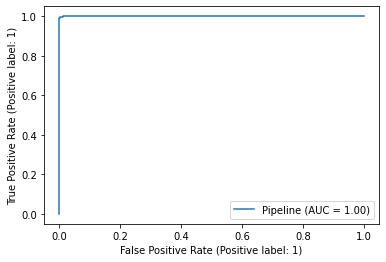

In [ ]:
X = np.array(features_list)
y = np.array(label_of_test_set)
metrics.plot_roc_curve(loaded_model, X, y) 
plt.savefig("res01.jpg")

##**precision_recall_curve**

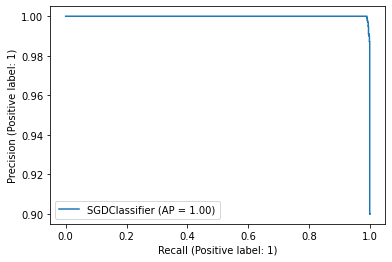

In [ ]:
y_score = loaded_model.decision_function(X)
display = PrecisionRecallDisplay.from_predictions(y, y_score, name="SGDClassifier")
plt.savefig("res02.jpg")

#**AP** 

In [ ]:
y_score = loaded_model.decision_function(X)
average_precision_score(y, y_score)

0.9999385724131903

##**main code**

In [ ]:
esteghlal=plt.imread("/content/Persepolis.jpg")
result=face_detection(esteghlal,loaded_model,[128,128])

In [ ]:
nms_box = nms(np.array(result), 0.1)

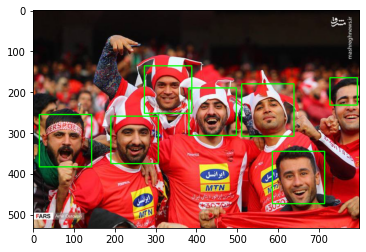

In [ ]:
img=np.copy(esteghlal)
for (startX, startY, endX, endY) in nms_box:
		cv2.rectangle(img, (startX, startY), (endX, endY), (0, 255, 0), 2)
# Displaying the image 
plt.imshow(img.astype(np.uint8))
plt.show()
plt.imsave("res06.jpg",img.astype(np.uint8))